# 1. Подготовка

## 1.1. Загрузка данных

In [2]:
import pandas as pd
import numpy as np

import skfuzzy as fuzz
from skfuzzy import control as ctrl

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

pd.set_option('display.precision', 3);
%matplotlib inline

In [346]:
data = pd.read_csv("../bike-sharing-dataset-clean.csv", # путь к файлу, используй автодотолнение
                   sep=',', # разделитель данных в файле
                   header=0 # номер строки с заголовками. header='None', если заголовки отсутствуют
                  )

In [279]:
features = [u'hr', u'temp', u'hum']
target = [u'cnt']

In [280]:
data.shape

(17357, 18)

In [281]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17357 entries, 0 to 17356
Data columns (total 18 columns):
Unnamed: 0    17357 non-null int64
instant       17357 non-null int64
dteday        17357 non-null object
season        17357 non-null int64
yr            17357 non-null int64
mnth          17357 non-null int64
hr            17357 non-null int64
holiday       17357 non-null int64
weekday       17357 non-null int64
workingday    17357 non-null int64
weathersit    17357 non-null int64
temp          17357 non-null float64
atemp         17357 non-null float64
hum           17357 non-null float64
windspeed     17357 non-null float64
casual        17357 non-null int64
registered    17357 non-null int64
cnt           17357 non-null int64
dtypes: float64(4), int64(13), object(1)
memory usage: 2.4+ MB


In [282]:
data.describe(include='all') 

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17357.000,17357.000,17357,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000,17357.000
unique,NaN,NaN,730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8698.034,8699.034,NaN,2.504,0.503,6.542,11.546,0.029,3.002,0.682,1.423,0.497,0.476,0.628,0.190,35.719,153.949,189.667
std,5013.782,5013.782,NaN,1.106,0.500,3.439,6.915,0.167,2.007,0.466,0.637,0.193,0.172,0.192,0.122,49.322,151.382,181.409
min,0.000,1.000,NaN,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.020,0.000,0.080,0.000,0.000,0.000,1.000
25%,4361.000,4362.000,NaN,2.000,0.000,4.000,6.000,0.000,1.000,0.000,1.000,0.340,0.333,0.480,0.104,4.000,34.000,40.000
50%,8700.000,8701.000,NaN,3.000,1.000,7.000,12.000,0.000,3.000,1.000,1.000,0.500,0.485,0.630,0.194,17.000,116.000,142.000
75%,13039.000,13040.000,NaN,3.000,1.000,10.000,18.000,0.000,5.000,1.000,2.000,0.660,0.621,0.780,0.254,48.000,220.000,281.000


In [283]:
data_origin = data

## 1.2. Коэфф. корреляции

In [284]:
corr_matrix_all = data.corr()

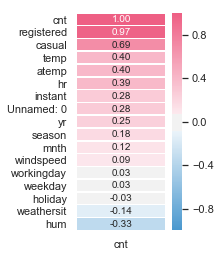

In [285]:
# цветовая карта
p = sns.diverging_palette(240, # HSV тон положительного
                          0,   # HSV тон отрицательного
                          s=80, # насыщенность.
                          l=60, # яркость
                          sep=20, # ширина центральной "нечувствительной" области
                          n=6,
                          center='light',
                          as_cmap=True)

plt.figure(figsize=(2,4))

# выбор столбца матрицы корреляции с значениями для целевой переменной 
corr_sorted = corr_matrix_all[ target ] \
  .sort_values(target, axis=0, ascending=False) # сортировка значений

# вывод в виде тепловой карты
sns.heatmap(
   data=corr_sorted,  # данные
   cmap=p,  # цветовая карта
   annot=True, # вывод значений
   fmt=".2f", # формат вывода значений
   vmin=-1, vmax=1, # граничные значения для цветовой карты 
   linewidths=.5, # расстояние между ячейками
);

# 2. Модель нечеткой логики

## 2.1 Описание

Определим граничные значения диапазонов для выбранных независимых признаков и целевой переменной.

In [286]:
pd.concat( [ 
        data[features+target].min(),
        data[features+target].max(),
    ],
    axis=1,
    keys=['min', 'max'])

,min,max
hr,0.00,23.0
temp,0.02,1.0
hum,0.08,1.0
cnt,1.00,977.0


## 2.2. Формирование базового набора ЛП

Задать Лингвистические переменные (ЛП). 
- Для входных ЛП(независимых признаков) используем класс __skfuzzy.control.Antecedent(universe, label)__
- Для выходных ЛП(целевой переменной) используем класс  __skfuzzy.control.Consequent(universe, label)__, где
    * universe - числовой диапазон значений;
    * label - текстовая наименование ЛП.

In [287]:
print "Входные (Antecedent - посылка)"
for i in range(0, len(features)):
    print "  {} - Универс: [{}, {}]".format(features[i], data[features].min()[i], data[features].max()[i])
print ""   
print "Выходные (Consequent - заключение)"
print "  {} - Универс: [{}, {}]".format(target[0], data[target].min()[0], data[target].max()[0])

Входные (Antecedent - посылка)
  hr - Универс: [0.0, 23.0]
  temp - Универс: [0.02, 1.0]
  hum - Универс: [0.08, 1.0]

Выходные (Consequent - заключение)
  cnt - Универс: [1, 977]


Для всех лингвистических переменных (ЛП) определить диапазон допустимых значений и задать имя типа(входные - Antecedent,выходные -Consequent).

In [288]:
# посылка - Время суток (hr)[0.0, 23.0] 
hr_un = np.arange(0, 23+1, 1)
lv_hr = ctrl.Antecedent(hr_un, "hr")

# посылка - Температура (temp) [0.02, 1.0]
temp_un = np.arange(0.02, 1+0.02, 0.02) #10)
lv_temp = ctrl.Antecedent(temp_un, "temp")

# посылка - Влажность (hum) [0.08, 1.0]
hum_un = np.arange(0.08, 1+0.01, 0.01) #100)
lv_hum = ctrl.Antecedent(hum_un, "hum")

# заключение - Количество клиентов в день (cnt) [1, 977]
cnt_un = np.arange(1, 977+5, 5) # 250000)
lv_cnt = ctrl.Consequent(cnt_un, "cnt")

In [289]:
data

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.288,0.81,0.000,3,13,16
1,1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.273,0.80,0.000,8,32,40
2,2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.273,0.80,0.000,5,27,32
3,3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.288,0.75,0.000,3,10,13
4,4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.288,0.75,0.000,0,1,1
5,5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.258,0.75,0.090,0,1,1
6,6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.273,0.80,0.000,2,0,2
7,7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.258,0.86,0.000,1,2,3
8,8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.288,0.75,0.000,1,7,8
9,9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.348,0.76,0.000,8,6,14


In [290]:
print "*", len(lv_hr.universe),     lv_hr.label,     lv_hr.universe
print "*", len(lv_temp.universe), lv_temp.label, lv_temp.universe
print "*", len(lv_hum.universe),  lv_hum.label,  lv_hum.universe
print "*", len(lv_cnt.universe),     lv_cnt.label,     lv_cnt.universe

* 24 hr [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
* 50 temp [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
* 93 hum [0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21
 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35
 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49
 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
* 197 cnt [  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 176
 181 186 191 19

## 2.3. Формирование базовых терм-множеств

Примеры распределений:

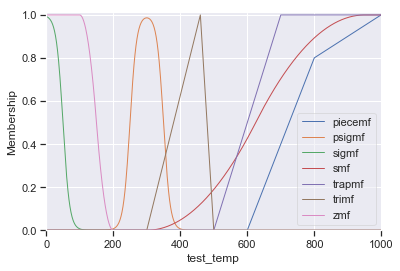

In [291]:
test_temp_un = np.arange(0, 1000, 1)
test_temp = ctrl.Antecedent(test_temp_un, 'test_temp')

test_temp[u"piecemf"] = fuzz.piecemf (test_temp.universe, [600, 800,1000])
test_temp[u"psigmf"]  = fuzz.psigmf  (test_temp.universe, 250, 0.1, 350, -0.1)
test_temp[u"sigmf"]   = fuzz.sigmf   (test_temp.universe, 50, -0.1) # параметры: центр вероятности 0.5, коэфф. сглаженности
test_temp[u"smf"]     = fuzz.smf     (test_temp.universe, 300, 950) # параметры: точка 0,   точка 1; Не может быть убывающей
test_temp[u"trapmf"]  = fuzz.trapmf  (test_temp.universe,  [500, 700,1000,1000] )
test_temp[u"trimf"]   = fuzz.trimf   (test_temp.universe, [300, 460, 500])
test_temp[u"zmf"]     = fuzz.zmf     (test_temp.universe, 100, 200)
test_temp.view()

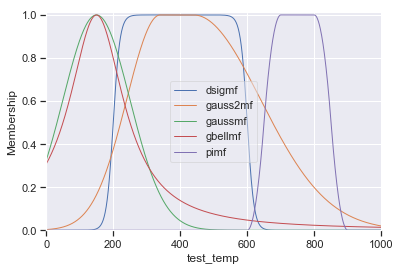

In [292]:
test_temp_un = np.arange(0, 1000, 1)
test_temp = ctrl.Antecedent(test_temp_un, u'test_temp')

test_temp[u"dsigmf"]   = fuzz.dsigmf   (test_temp.universe, 200, 0.1, 600, 0.1)
test_temp[u"gauss2mf"] = fuzz.gauss2mf (test_temp.universe, 340, 100, 440, 200)
test_temp[u"gaussmf"]  = fuzz.gaussmf  (test_temp.universe, 150, 100)
test_temp[u"gbellmf"]  = fuzz.gbellmf  (test_temp.universe, 100,1, 150)
test_temp[u"pimf"]     = fuzz.pimf     (test_temp.universe, 600, 700, 800,900)
test_temp.view()

### 2.3.2. Формирование терм-множеств

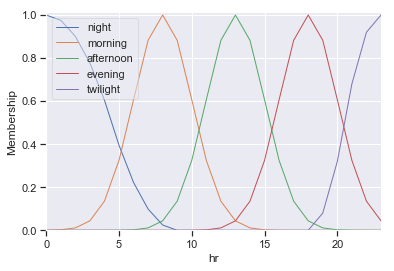

In [293]:
# Время суток (hr) [0, 23] = {"morning", "afternoon", "evening", "night"}
lv_hr["night"]  = fuzz.zmf (lv_hr.universe, 0, 9)
lv_hr["morning"] = fuzz.gaussmf   (lv_hr.universe, 8, 2)
lv_hr["afternoon"]  = fuzz.gaussmf  (lv_hr.universe, 13, 2)
lv_hr["evening"]  = fuzz.gaussmf (lv_hr.universe, 18, 2)
lv_hr["twilight"]  = fuzz.smf (lv_hr.universe, 18, 23)
lv_hr.view()

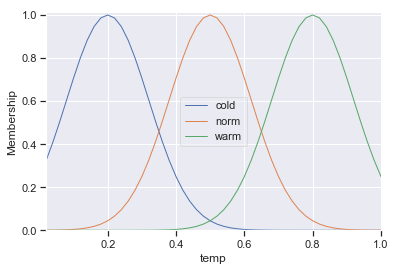

In [294]:
# Температура (temp) [0.02, 1.0] = {"cold", "norm", "warm"}
lv_temp["cold"] = fuzz.gaussmf   (lv_temp.universe, 0.2, 0.12)
lv_temp["norm"]  = fuzz.gaussmf  (lv_temp.universe, 0.5, 0.12)
lv_temp["warm"]  = fuzz.gaussmf (lv_temp.universe, 0.8, 0.12)
lv_temp.view()

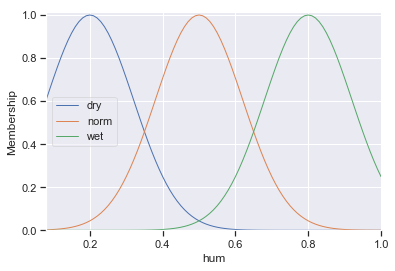

In [295]:
# Влажность (hum) [0.08, 1.0] = {"dry", "norm", "wet"}
lv_hum["dry"] = fuzz.gaussmf   (lv_hum.universe, 0.2, 0.12)
lv_hum["norm"]  = fuzz.gaussmf  (lv_hum.universe, 0.5, 0.12)
lv_hum["wet"]  = fuzz.gaussmf (lv_hum.universe, 0.8, 0.12)
lv_hum.view()

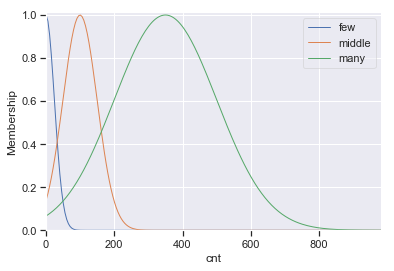

In [296]:
# Количество клиентов в день (cnt) [1, 977] = {"few", "middle", "many"}
lv_cnt["few"] = fuzz.gaussmf   (lv_cnt.universe, 0, 25)
lv_cnt["middle"]  = fuzz.gaussmf  (lv_cnt.universe, 100, 50)
lv_cnt["many"]  = fuzz.gaussmf (lv_cnt.universe, 350, 150)
lv_cnt.view()

Text(0.5,1,u'\u0413\u0440\u0430\u0444\u0438\u043a \u0440\u0430\u0441\u043f\u0440\u0435\u0434\u0435\u043b\u0435\u043d\u0438\u044f \u0432\u0435\u043b\u0438\u0447\u0438\u043d\u044b')

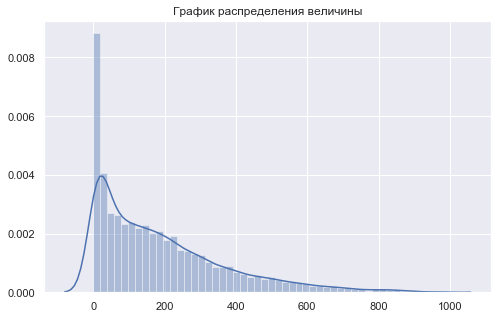

In [297]:
plt.figure(figsize=(8,5))
sns.distplot(data[target],  hist=True) # Ядерная оценка плотности (KDE - Kernel density estimation)
plt.title(u'График распределения величины')

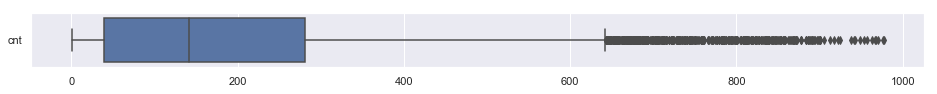

In [298]:
plt.figure(figsize=(16, 1))
sns.boxplot( data=data[['cnt']], orient="h")

## 2.4. Формирование нечеткой базы знаний

Создадим правила используя класс 
  __skfuzzy.control.Rule(antecedent=None, consequent=None, label=None )__, где
    - antecedent исходные посылки(термы входных ЛП);
    - consequent заключения (термы выходной ЛП);
    - label название правила.
      
При формировании базы знаний обязательно для всех термов выходной ЛП задать не менне одного правила.

In [299]:
#1) ЕСЛИ () ИЛИ (), ТО ().
rule_1 = ctrl.Rule(
    lv_hr["morning"] & lv_temp["norm"] & lv_hum["norm"],
    lv_cnt["many"],
    "firstRule")

#2) ЕСЛИ () ИЛИ (), ТО ().
rule_2 = ctrl.Rule(
    lv_hr["morning"] & (lv_hum["wet"] |  lv_hum["dry"]),
    lv_cnt["few"],
    "secondRule")

#3) ЕСЛИ () ИЛИ (), ТО ().
rule_3 = ctrl.Rule(
    lv_hr["afternoon"] & ( lv_temp["cold"]  | lv_temp["warm"] ),
    lv_cnt["middle"],
    "thirdRule")

#4) ЕСЛИ () ИЛИ (), ТО ().
rule_4 = ctrl.Rule(
    lv_hr["afternoon"] & ( lv_hum["norm"]  | lv_temp["norm"] ),
    lv_cnt["many"],
    "fourthRule")

#5) ЕСЛИ () ИЛИ (), ТО ().
rule_5 = ctrl.Rule(
    lv_hr["night"] ,
    lv_cnt["few"],
    "fivehRule")

#6) ЕСЛИ () ИЛИ (), ТО ().
rule_6 = ctrl.Rule(
    lv_hr["evening"] & ( lv_hum["norm"]  | lv_temp["norm"] ) ,
    lv_cnt["many"],
    "sixthRule")

#7) ЕСЛИ () ИЛИ (), ТО ().
rule_7 = ctrl.Rule(
    lv_hr["twilight"],
    lv_cnt["few"],
    "seventhRule")

#8) ЕСЛИ () ИЛИ (), ТО ().
rule_8 = ctrl.Rule(
    lv_hum["wet"]  & lv_temp["cold"],
    lv_cnt["few"],
    "eighthRule")

## 2.5. Тестирование нечеткой базы знаний

## 2.5.1. Этап подготовки

Раздление работы с моделью необходимо последовательно создать объекты:
- __skfuzzy.control.ControlSystem(rules, ...)__ объединияющий выбранные правила
- __skfuzzy.control.ControlSystemSimulation(control_system, ...)__ позволяющий зделать расчет на основе входных значений

In [300]:
cnt_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8])
cnt_SIM = ctrl.ControlSystemSimulation(cnt_ctrl)

In [301]:
# Создадим функцию для вывода степени вероятности принадлежности переданного значения
def printTerm(lingVal, value):
    print "\n  {:>10} = {:>10}".format(lingVal.label, value[0]),
    for term in lingVal.terms:
        print "{} {:>7} {:.2f},".format(" ", term, fuzz.interp_membership( lingVal.universe, lingVal[term].mf,   value[0])),

Сформируем тестовое множество

In [302]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 12149, y_train 12149 
  x_test:  5208, y_test  5208 
  total x: 17357, total y 17357 


## 2.5.2. Проверка работы модели

In [303]:
print "Вывод значений проверочной части данных"
start_index = 0
stop_index = 3
for i in range(start_index, stop_index):
    print "{}, {}, {}; y:{}".format(
    x_test[features].iloc[i][0],
    x_test[features].iloc[i][1],
    x_test[features].iloc[i][2], y_test.iloc[i][0] )

Вывод значений проверочной части данных
15.0, 0.2, 0.47; y:49
4.0, 0.34, 0.87; y:8
17.0, 0.76, 0.62; y:555


In [304]:
in_hr = [12]
in_hum = [0.6]
in_temp = [0.55]

cnt_SIM.input['hr']     = in_hr  # x_test[features].iloc[0][0]
cnt_SIM.input['temp'] = in_temp # x_test[features].iloc[0][1]
cnt_SIM.input['hum']  = in_hum  # x_test[features].iloc[0][2]

print "Степень принадлежности значений к каждому терму:",
printTerm(lv_hr, in_hr)
printTerm(lv_temp, in_temp)
printTerm(lv_hum, in_hum)

Степень принадлежности значений к каждому терму: 
          hr =         12     night 0.00,   morning 0.14,   afternoon 0.88,   evening 0.01,   twilight 0.00, 
        temp =       0.55      cold 0.01,      norm 0.91,      warm 0.12, 
         hum =        0.6       dry 0.00,      norm 0.71,       wet 0.25,


In [305]:
# Вычисление
cnt_SIM.compute()

# Вывод результата
print "calc={:,.2f}, real= {:,.2f}  delta={:,.2f}".format (cnt_SIM.output['cnt'], y_test.iloc[1][0], (cnt_SIM.output['cnt'] - y_test.iloc[1][0]))

calc=352.46, real= 8.00  delta=344.46


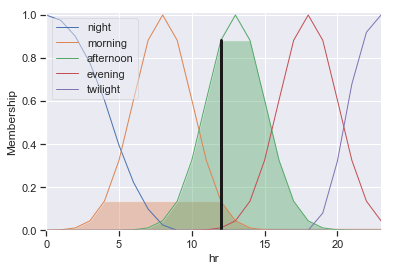

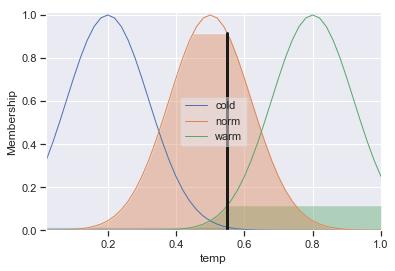

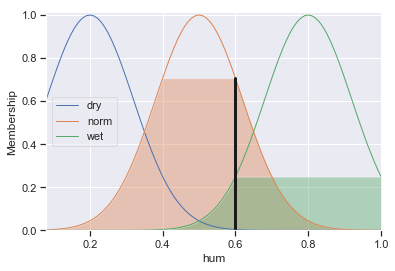

In [306]:
lv_hr.view(sim=cnt_SIM)
lv_temp.view(sim=cnt_SIM)
lv_hum.view(sim=cnt_SIM)

Проанализируем ход получения результата

In [307]:
cnt_SIM.print_state()

 Antecedents 
Antecedent: temp                    = [0.55]
  - cold                            : [0.014586]
  - norm                            : [0.91422819]
  - warm                            : [0.11548486]
Antecedent: hr                      = [12]
  - night                           : [0.]
  - morning                         : [0.13533528]
  - afternoon                       : [0.8824969]
  - evening                         : [0.011109]
  - twilight                        : [0.]
Antecedent: hum                     = [0.6]
  - dry                             : [0.00386592]
  - norm                            : [0.70664828]
  - wet                             : [0.24935221]

 Rules 
RULE #0:
  IF hum[wet] AND temp[cold] THEN cnt[few]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - hum[wet]                                               : [0.24935221]
  - temp[cold]                                             : [0.014586]
             

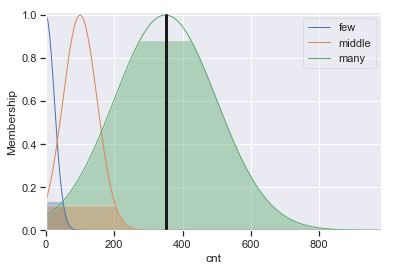

In [308]:
lv_cnt.view(sim=cnt_SIM)

## 2.5.3. Проверка работы модели на проверочной части выборки

In [309]:
y_pred = np.array([])
start_index = 105
stop_index = 155

for i in range (start_index, stop_index):
    print "row", i,
    
    #очередные значения
    in_hr    = x_test[features].iloc[i][0],
    in_temp     = x_test[features].iloc[i][1],
    in_hum = x_test[features].iloc[i][2], 
    out_cnt   = y_test.iloc[i][0]

    # задать значения в модель нечеткой логики
    cnt_SIM.input['hr']     = in_hr
    cnt_SIM.input['temp'] = in_temp
    cnt_SIM.input['hum']  = in_hum
    
    print "Степень принадлежности значений к каждому терму:",
    printTerm(lv_hr, in_hr)
    printTerm(lv_temp, in_temp)
    printTerm(lv_hum, in_hum)
    
    # Вычисление
    cnt_SIM.compute()

    # Вывод результата
    y_pred = np.append(y_pred, cnt_SIM.output['cnt'])
    print ""
    print "{} calc={:.2f}, true={:.2f}".format(target[0], cnt_SIM.output['cnt'], out_cnt) 
    print ""

row 105 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 0.32,   evening 0.61,   twilight 0.00, 
        temp =       0.72      cold 0.00,      norm 0.19,      warm 0.80, 
         hum =       0.37       dry 0.37,      norm 0.56,       wet 0.00, 
cnt calc=338.49, true=426.00

row 106 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night 0.00,   morning 0.32,   afternoon 0.61,   evening 0.00,   twilight 0.00, 
        temp =       0.52      cold 0.03,      norm 0.99,      warm 0.07, 
         hum =       0.48       dry 0.07,      norm 0.99,       wet 0.03, 
cnt calc=355.04, true=229.00

row 107 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night 0.00,   morning 0.04,   afternoon 1.00,   evening 0.04,   twilight 0.00, 
        temp =       0.54      cold 0.02,      norm 0.95,      warm 0.10, 
         hum =       0.49       dry 0.05,      norm 1.00,    

         hum =        0.7       dry 0.00,      norm 0.25,       wet 0.71, 
cnt calc=303.94, true=7.00

row 130 Степень принадлежности значений к каждому терму: 
          hr =        0.0     night 1.00,   morning 0.00,   afternoon 0.00,   evening 0.00,   twilight 0.00, 
        temp =       0.28      cold 0.80,      norm 0.19,      warm 0.00, 
         hum =       0.65       dry 0.00,      norm 0.46,       wet 0.46, 
cnt calc=25.56, true=32.00

row 131 Степень принадлежности значений к каждому терму: 
          hr =        2.0     night 0.90,   morning 0.01,   afternoon 0.00,   evening 0.00,   twilight 0.00, 
        temp =       0.52      cold 0.03,      norm 0.99,      warm 0.07, 
         hum =       0.77       dry 0.00,      norm 0.08,       wet 0.97, 
cnt calc=119.48, true=12.00

row 132 Степень принадлежности значений к каждому терму: 
          hr =        6.0     night 0.22,   morning 0.61,   afternoon 0.00,   evening 0.00,   twilight 0.00, 
        temp =       0.22      cold 

In [310]:
target

[u'cnt']

In [311]:
data_part = data[target] [start_index:stop_index]

In [312]:
stop_index

155

In [313]:
data[target] [start_index:stop_index].head()

,cnt
105,62
106,62
107,89
108,190
109,169


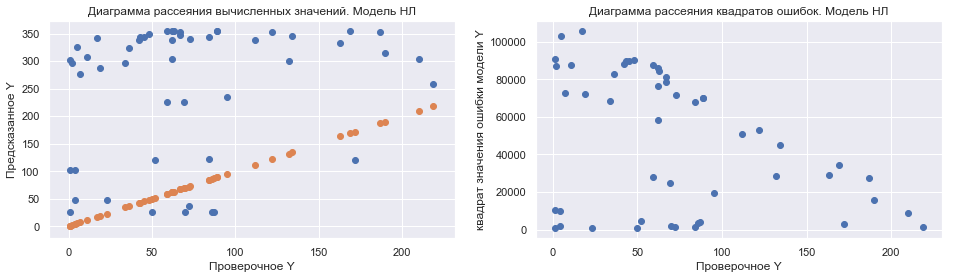

In [314]:
# вывод
if (len (y_pred) == len (data_part)):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter( data_part, y_pred.reshape(-1, 1) )
    plt.scatter( data_part, data_part,)
    plt.title(u'Диаграмма рассеяния вычисленных значений. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'Предсказанное Y')
    
    plt.subplot(122)
    plt.scatter( data_part, pow( data_part - y_pred.reshape(-1, 1), 2 ) )
    plt.title(u'Диаграмма рассеяния квадратов ошибок. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'квадрат значения ошибки модели Y')

else:
    print len (y_pred), len (data_part), "Размеры массивоов не совпадают"

In [315]:
print len (y_pred), len (data_part)

50 50


In [316]:
print data_part.head()

     cnt
105   62
106   62
107   89
108  190
109  169


In [317]:
r2 = metrics.r2_score( data_part, y_pred.reshape(-1, 1))
mae = metrics.mean_absolute_error(data_part, y_pred.reshape(-1, 1))
mse = metrics.mean_squared_error(data_part, y_pred.reshape(-1, 1))

In [318]:
print "r2  = {:>20.2f}".format(r2)
print "mae = {:>20.2f}".format(mae)
print "mse = {:>20.2f}".format(mse)

r2  =               -13.26
mae =               192.03
mse =             47412.81


## 3. Доработка базы знаний и тестирование усовершенствованной модели. 

In [319]:
#Разделить данные на два года
#Доработать базу знаний

In [320]:
data_2011 = data[ ~ (data['yr'] != 0)]

### 3.1. Редактирование терм-множеств

In [321]:
# посылка - Время суток (hr)[0.0, 23.0] 
hr_un = np.arange(0, 23+1, 1)
lv_hr = ctrl.Antecedent(hr_un, "hr")

# посылка - Температура (temp) [0.02, 1.0]
temp_un = np.arange(0.02, 1+0.02, 0.02) #10)
lv_temp = ctrl.Antecedent(temp_un, "temp")

# посылка - Влажность (hum) [0.08, 1.0]
hum_un = np.arange(0.08, 1+0.01, 0.01) #100)
lv_hum = ctrl.Antecedent(hum_un, "hum")

# заключение - Количество клиентов в день (cnt) [1, 977]
cnt_un = np.arange(1, 977+5, 5) # 250000)
lv_cnt = ctrl.Consequent(cnt_un, "cnt")

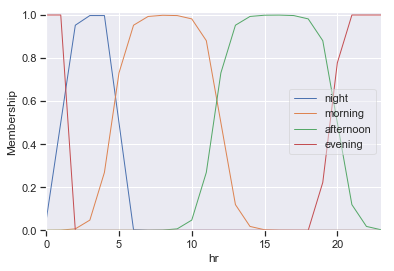

In [322]:
# Время суток (hr) [0, 23] = {"morning", "afternoon", "evening", "night"}
lv_hr["night"]  = fuzz.dsigmf(lv_hr.universe, 1, 3, 5, 6) 
lv_hr["morning"] = fuzz.dsigmf(lv_hr.universe, 4.5, 2, 12, 2)
lv_hr["afternoon"]  = fuzz.dsigmf(lv_hr.universe, 11.5, 2, 20, 2)
lv_hr["evening"]  = fuzz.smf(lv_hr.universe, 18, 21) + fuzz.zmf(lv_hr.universe, 1, 2)
#lv_hr["twilight"]  = fuzz.smf (lv_hr.universe, 18, 23)
lv_hr.view()

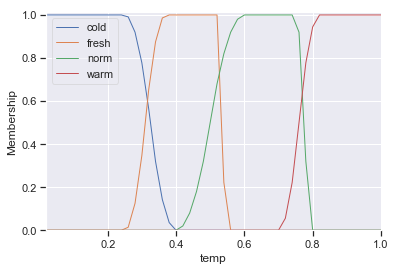

In [323]:
# Температура (temp) [0.02, 1.0] = {"cold", "norm", "warm"}
lv_temp["cold"] = fuzz.zmf   (lv_temp.universe, 0.25, 0.4)
lv_temp["fresh"] = fuzz.pimf   (lv_temp.universe, 0.25, 0.37, 0.52, 0.55)
lv_temp["norm"]  = fuzz.pimf  (lv_temp.universe, 0.4, 0.6, 0.75, 0.8)
lv_temp["warm"]  = fuzz.smf (lv_temp.universe, 0.7, 0.82)
lv_temp.view()

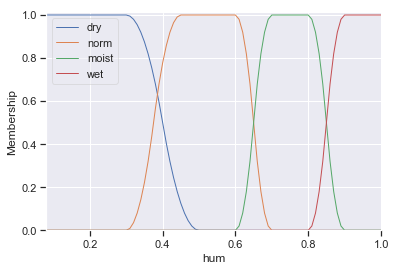

In [324]:
# Влажность (hum) [0.08, 1.0] = {"dry", "norm", "wet"}
lv_hum["dry"] = fuzz.zmf   (lv_hum.universe, 0.3, 0.5)
lv_hum["norm"]  = fuzz.pimf  (lv_hum.universe, 0.3, 0.45, 0.6, 0.7)
lv_hum["moist"]  = fuzz.pimf  (lv_hum.universe, 0.6, 0.7, 0.8, 0.9)
lv_hum["wet"]  = fuzz.smf   (lv_hum.universe, 0.8, 0.9)
lv_hum.view()

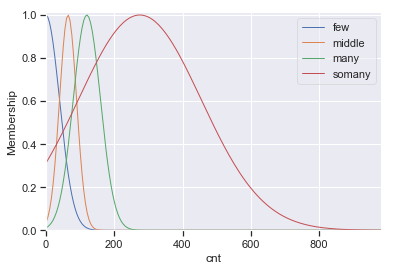

In [325]:
# Количество клиентов в день (cnt) [1, 977] = {"few", "middle", "many"}
lv_cnt["few"] = fuzz.gaussmf   (lv_cnt.universe, 0, 40)
lv_cnt["middle"]  = fuzz.gaussmf  (lv_cnt.universe, 65, 25)
lv_cnt["many"]  = fuzz.gaussmf (lv_cnt.universe, 120, 40)
lv_cnt["somany"]  = fuzz.gaussmf (lv_cnt.universe, 275,180)
lv_cnt.view()

### 3.2. Доработка нечеткой базы знаний

In [326]:
#cnt = 'few'

rule_1 = ctrl.Rule(
    lv_hr["night"] ,
    lv_cnt["few"],
    "firstRule")

rule_2 = ctrl.Rule(
    lv_hr["morning"] & lv_temp["cold"] & lv_hum["wet"],
    lv_cnt["few"],
    "secondRule")


#cnt = 'middle'

rule_3 = ctrl.Rule(
    lv_hr["morning"] & lv_temp["fresh"],
    lv_cnt["middle"],
    "thirdRule")


rule_4 = ctrl.Rule(
    lv_hr["morning"] & ( lv_temp["fresh"]  | lv_temp["norm"] ) & lv_hum["wet"],
    lv_cnt["middle"],
    "forthRule")

rule_5 = ctrl.Rule(
    lv_hr["morning"] & ( lv_hum["dry"] | lv_hum["norm"]  | lv_hum["moist"] ) & lv_temp["cold"],
    lv_cnt["middle"],
    "fivthRule")

rule_6 = ctrl.Rule(
    lv_hr["evening"] & lv_temp["cold"],
    lv_cnt["middle"],
    "sixthRule")

#cnt = 'many'

rule_7 = ctrl.Rule(
    lv_hr["morning"] & ( lv_temp["norm"]  | lv_temp["warm"] ),
    lv_cnt["many"],
    "seventhRule")


rule_8 = ctrl.Rule(
    lv_hr["morning"] & lv_temp["fresh"] & ( lv_hum["norm"] | lv_hum["dry"]),
    lv_cnt["many"],
    "eighthRule")

rule_9 = ctrl.Rule(
    lv_hr["afternoon"] & lv_temp["cold"],
    lv_cnt["many"],
    "ninthRule")

rule_10 = ctrl.Rule(
     lv_hr["evening"] & lv_temp["fresh"],
     lv_cnt["many"],
    "tenthRule")

rule_11 = ctrl.Rule(
    lv_hr["evening"] & (lv_temp["norm"] | lv_temp["warm"]) & lv_hum["wet"],
    lv_cnt["many"],
    "elevenRule")    
    
#cnt = 'somany'

rule_12 = ctrl.Rule(
    lv_hr["morning"] & (lv_hum["dry"] | lv_hum["norm"]) & (lv_temp["norm"] | lv_temp["warm"]),
    lv_cnt["somany"],
    "twelveRule")
    
rule_13 = ctrl.Rule(
    lv_hr["afternoon"] & (lv_hum["dry"] | lv_hum["norm"]) & (lv_temp["norm"] | lv_temp["warm"]),
    lv_cnt["somany"],
    "thirteenRule")  
    
rule_14 = ctrl.Rule(
    lv_hr["evening"] & (lv_hum["dry"] | lv_hum["norm"]) & (lv_temp["norm"] | lv_temp["warm"]),
    lv_cnt["somany"],
    "thirteenRule")      

### 3.3. Тестирование доработанной базы знаний

In [327]:
cnt_ctrl = ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10, rule_11, rule_12, rule_13, rule_14])
cnt_SIM = ctrl.ControlSystemSimulation(cnt_ctrl)

In [328]:
# Создадим функцию для вывода степени вероятности принадлежности переданного значения
def printTerm(lingVal, value):
    print "\n  {:>10} = {:>10}".format(lingVal.label, value[0]),
    for term in lingVal.terms:
        print "{} {:>7} {:.2f},".format(" ", term, fuzz.interp_membership( lingVal.universe, lingVal[term].mf,   value[0])),

In [329]:
# Формирование тестового множества

In [330]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data[features], data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 12149, y_train 12149 
  x_test:  5208, y_test  5208 
  total x: 17357, total y 17357 


### 3.4. Проверка работы доработанной модели

In [331]:
print "Вывод значений проверочной части данных"
start_index = 0
stop_index = 3
for i in range(start_index, stop_index):
    print "{}, {}, {}; y:{}".format(
    x_test[features].iloc[i][0],
    x_test[features].iloc[i][1],
    x_test[features].iloc[i][2], y_test.iloc[i][0] )

Вывод значений проверочной части данных
15.0, 0.2, 0.47; y:49
4.0, 0.34, 0.87; y:8
17.0, 0.76, 0.62; y:555


In [332]:
in_hr = [6]
in_hum = [0.9]
in_temp = [0.20]

cnt_SIM.input['hr']     = in_hr  # x_test[features].iloc[0][0]
cnt_SIM.input['temp'] = in_temp # x_test[features].iloc[0][1]
cnt_SIM.input['hum']  = in_hum  # x_test[features].iloc[0][2]

print "Степень принадлежности значений к каждому терму:",
printTerm(lv_hr, in_hr)
printTerm(lv_temp, in_temp)
printTerm(lv_hum, in_hum)

Степень принадлежности значений к каждому терму: 
          hr =          6     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        temp =        0.2      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =        0.9       dry 0.00,      norm 0.00,     moist 0.00,       wet 1.00,


In [333]:
# Вычисление
cnt_SIM.compute()

# Вывод результата
print "calc={:,.2f}, real= {:,.2f}  delta={:,.2f}".format (cnt_SIM.output['cnt'], y_test.iloc[1][0], (cnt_SIM.output['cnt'] - y_test.iloc[1][0]))

calc=32.79, real= 8.00  delta=24.79


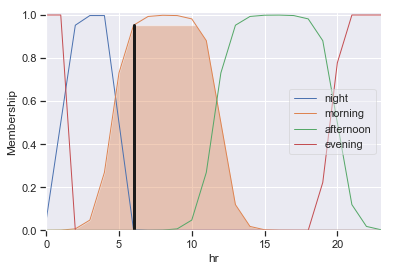

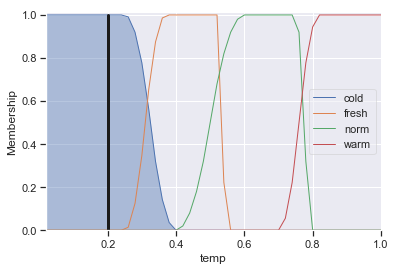

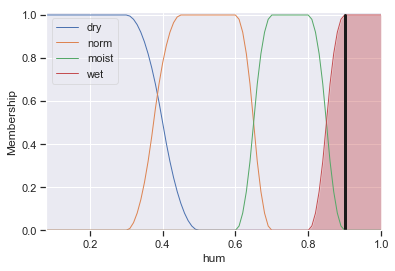

In [334]:
lv_hr.view(sim=cnt_SIM)
lv_temp.view(sim=cnt_SIM)
lv_hum.view(sim=cnt_SIM)

In [335]:
cnt_SIM.print_state()

 Antecedents 
Antecedent: hum                     = [0.9]
  - dry                             : [0.]
  - norm                            : [0.]
  - moist                           : [3.94430453e-29]
  - wet                             : [1.]
Antecedent: temp                    = [0.2]
  - cold                            : [1.]
  - fresh                           : [0.]
  - norm                            : [0.]
  - warm                            : [0.]
Antecedent: hr                      = [6]
  - night                           : [0.00247232]
  - morning                         : [0.95256798]
  - afternoon                       : [1.67014212e-05]
  - evening                         : [0.]

 Rules 
RULE #0:
  IF hr[evening] AND temp[cold] THEN cnt[middle]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - hr[evening]                                            : [0.]
  - temp[cold]                                             : [1.]
       

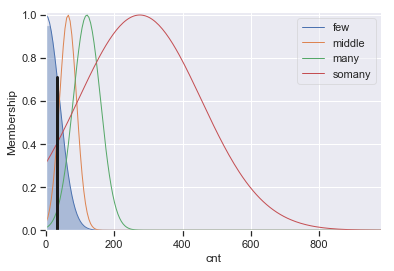

In [336]:
lv_cnt.view(sim=cnt_SIM)

### 3.5. Проверка работы модели на проверочной части выборки

In [337]:
y_pred = np.array([])
start_index = 105
stop_index = 155

for i in range (start_index, stop_index):
    print "row", i,
    
    #очередные значения
    in_hr    = x_test[features].iloc[i][0],
    in_temp     = x_test[features].iloc[i][1],
    in_hum = x_test[features].iloc[i][2], 
    out_cnt   = y_test.iloc[i][0]

    # задать значения в модель нечеткой логики
    cnt_SIM.input['hr']     = in_hr
    cnt_SIM.input['temp'] = in_temp
    cnt_SIM.input['hum']  = in_hum
    
    print "Степень принадлежности значений к каждому терму:",
    printTerm(lv_hr, in_hr)
    printTerm(lv_temp, in_temp)
    printTerm(lv_hum, in_hum)
    
    # Вычисление
    cnt_SIM.compute()

    # Вывод результата
    y_pred = np.append(y_pred, cnt_SIM.output['cnt'])
    print ""
    print "{} calc={:.2f}, true={:.2f}".format(target[0], cnt_SIM.output['cnt'], out_cnt) 
    print ""

row 105 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.72      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.06, 
         hum =       0.37       dry 0.76,      norm 0.44,     moist 0.00,       wet 0.00, 
cnt calc=301.77, true=426.00

row 106 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night -0.00,   morning 0.88,   afternoon 0.27,   evening 0.00, 
        temp =       0.52      cold 0.00,     fresh 1.00,      norm 0.68,      warm 0.00, 
         hum =       0.48       dry 0.02,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=287.22, true=229.00

row 107 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night -0.00,   morning 0.12,   afternoon 0.95,   evening 0.00, 
        temp =       0.54      cold 0.00,     fresh 0.22,      norm 0.82,      warm 0.00, 
         hum =       0.49     

         hum =        0.7       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=42.82, true=7.00

row 130 Степень принадлежности значений к каждому терму: 
          hr =        0.0     night 0.05,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.28      cold 0.92,     fresh 0.13,      norm 0.00,      warm 0.00, 
         hum =       0.65       dry 0.00,      norm 0.50,     moist 0.50,       wet 0.00, 
cnt calc=82.35, true=32.00

row 131 Степень принадлежности значений к каждому терму: 
          hr =        2.0     night 0.95,   morning 0.01,   afternoon 0.00,   evening 0.00, 
        temp =       0.52      cold 0.00,     fresh 1.00,      norm 0.68,      warm 0.00, 
         hum =       0.77       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=35.46, true=12.00

row 132 Степень принадлежности значений к каждому терму: 
          hr =        6.0     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        t

In [338]:
data_part = data[target] [start_index:stop_index]

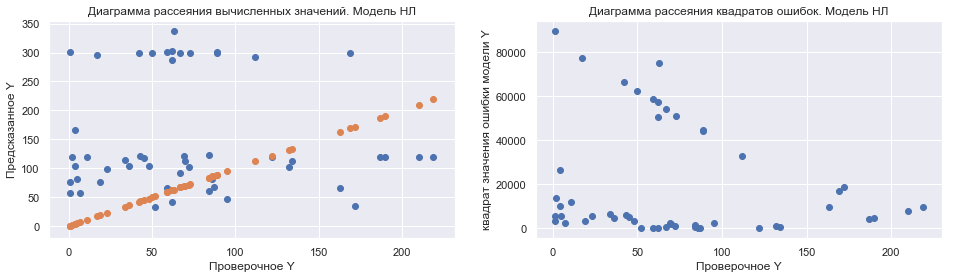

In [339]:
# вывод
if (len (y_pred) == len (data_part)):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter( data_part, y_pred.reshape(-1, 1) )
    plt.scatter( data_part, data_part,)
    plt.title(u'Диаграмма рассеяния вычисленных значений. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'Предсказанное Y')
    
    plt.subplot(122)
    plt.scatter( data_part, pow( data_part - y_pred.reshape(-1, 1), 2 ) )
    plt.title(u'Диаграмма рассеяния квадратов ошибок. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'квадрат значения ошибки модели Y')

else:
    print len (y_pred), len (data_part), "Размеры массивоов не совпадают"

In [340]:
r2 = metrics.r2_score( data_part, y_pred.reshape(-1, 1))
mae = metrics.mean_absolute_error(data_part, y_pred.reshape(-1, 1))
mse = metrics.mean_squared_error(data_part, y_pred.reshape(-1, 1))

In [341]:
print "r2  = {:>20.2f}".format(r2)
print "mae = {:>20.2f}".format(mae)
print "mse = {:>20.2f}".format(mse)

r2  =                -4.81
mae =               108.75
mse =             19299.84


### 3.6 Проверка работы модели на части выборки (только зимний сезон, season = 4)

Text(0.5,1,u'\u0413\u0440\u0430\u0444\u0438\u043a \u0440\u0430\u0441\u043f\u0440\u0435\u0434\u0435\u043b\u0435\u043d\u0438\u044f \u0432\u0435\u043b\u0438\u0447\u0438\u043d\u044b')

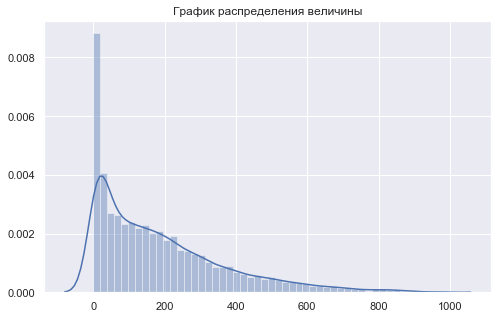

In [342]:
plt.figure(figsize=(8,5))
sns.distplot(data[target],  hist=True) # Ядерная оценка плотности (KDE - Kernel density estimation)
plt.title(u'График распределения величины')

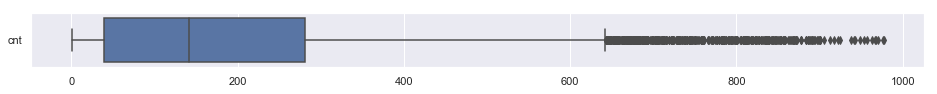

In [350]:
plt.figure(figsize=(16, 1))
sns.boxplot(data=data[['cnt']], orient="h")

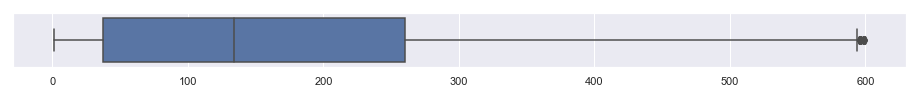

In [364]:
data_filtered = data[ ~ (data['cnt'] > 600 )]
plt.figure(figsize=(16, 1))
sns.boxplot(data_filtered[['cnt']], orient="h")

In [365]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    data_summer[features], data_summer[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 11741, y_train 11741 
  x_test:  5033, y_test  5033 
  total x: 16774, total y 16774 


In [366]:
print "Вывод значений проверочной части данных"
start_index = 0
stop_index = 3
for i in range(start_index, stop_index):
    print "{}, {}, {}; y:{}".format(
    x_test[features].iloc[i][0],
    x_test[features].iloc[i][1],
    x_test[features].iloc[i][2], y_test.iloc[i][0] )

Вывод значений проверочной части данных
1.0, 0.54, 0.6; y:101
21.0, 0.72, 0.84; y:136
3.0, 0.3, 0.65; y:6


In [367]:
in_hr = [6]
in_hum = [0.9]
in_temp = [0.20]

cnt_SIM.input['hr']     = in_hr  # x_test[features].iloc[0][0]
cnt_SIM.input['temp'] = in_temp # x_test[features].iloc[0][1]
cnt_SIM.input['hum']  = in_hum  # x_test[features].iloc[0][2]

print "Степень принадлежности значений к каждому терму:",
printTerm(lv_hr, in_hr)
printTerm(lv_temp, in_temp)
printTerm(lv_hum, in_hum)

Степень принадлежности значений к каждому терму: 
          hr =          6     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        temp =        0.2      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =        0.9       dry 0.00,      norm 0.00,     moist 0.00,       wet 1.00,


In [368]:
# Вычисление
cnt_SIM.compute()

# Вывод результата
print "calc={:,.2f}, real= {:,.2f}  delta={:,.2f}".format (cnt_SIM.output['cnt'], y_test.iloc[1][0], (cnt_SIM.output['cnt'] - y_test.iloc[1][0]))

calc=32.79, real= 136.00  delta=-103.21


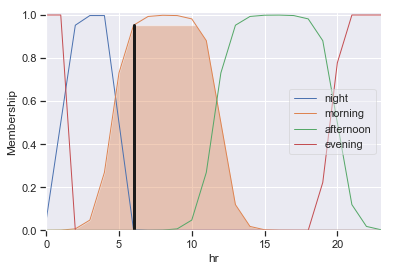

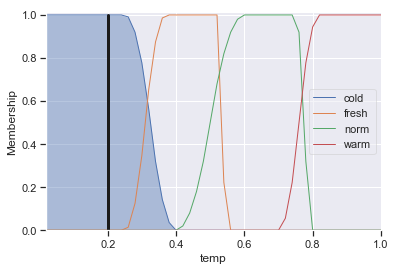

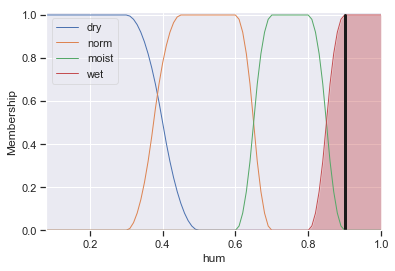

In [369]:
lv_hr.view(sim=cnt_SIM)
lv_temp.view(sim=cnt_SIM)
lv_hum.view(sim=cnt_SIM)

In [370]:
cnt_SIM.print_state()

 Antecedents 
Antecedent: hum                     = [0.9]
  - dry                             : [0.]
  - norm                            : [0.]
  - moist                           : [3.94430453e-29]
  - wet                             : [1.]
Antecedent: temp                    = [0.2]
  - cold                            : [1.]
  - fresh                           : [0.]
  - norm                            : [0.]
  - warm                            : [0.]
Antecedent: hr                      = [6]
  - night                           : [0.00247232]
  - morning                         : [0.95256798]
  - afternoon                       : [1.67014212e-05]
  - evening                         : [0.]

 Rules 
RULE #0:
  IF hr[evening] AND temp[cold] THEN cnt[middle]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - hr[evening]                                            : [0.]
  - temp[cold]                                             : [1.]
       

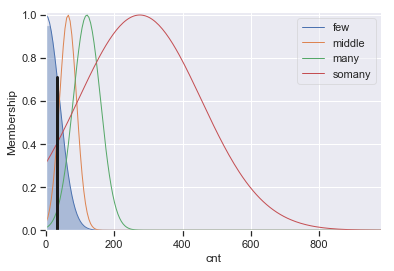

In [371]:
lv_cnt.view(sim=cnt_SIM)

In [376]:
y_pred = np.array([])
start_index = 0
stop_index = 1000

for i in range (start_index, stop_index):
    print "row", i,
    
    #очередные значения
    in_hr    = x_test[features].iloc[i][0],
    in_temp     = x_test[features].iloc[i][1],
    in_hum = x_test[features].iloc[i][2], 
    out_cnt   = y_test.iloc[i][0]

    # задать значения в модель нечеткой логики
    cnt_SIM.input['hr']     = in_hr
    cnt_SIM.input['temp'] = in_temp
    cnt_SIM.input['hum']  = in_hum
    
    print "Степень принадлежности значений к каждому терму:",
    printTerm(lv_hr, in_hr)
    printTerm(lv_temp, in_temp)
    printTerm(lv_hum, in_hum)
    
    # Вычисление
    cnt_SIM.compute()

    # Вывод результата
    y_pred = np.append(y_pred, cnt_SIM.output['cnt'])
    print ""
    print "{} calc={:.2f}, true={:.2f}".format(target[0], cnt_SIM.output['cnt'], out_cnt) 
    print ""

row 0 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.54      cold 0.00,     fresh 0.22,      norm 0.82,      warm 0.00, 
         hum =        0.6       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=296.73, true=101.00

row 1 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.72      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.06, 
         hum =       0.84       dry 0.00,      norm 0.00,     moist 0.68,       wet 0.32, 
cnt calc=120.37, true=136.00

row 2 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =       0.65       dry 0.

        temp =       0.62      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =        0.5       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.07, true=285.00

row 26 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.62      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.73       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=47.20, true=4.00

row 27 Степень принадлежности значений к каждому терму: 
          hr =        9.0     night 0.00,   morning 1.00,   afternoon 0.01,   evening 0.00, 
        temp =       0.64      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.89       dry 0.00,      norm 0.00,     moist 0.02,       wet 0.98, 
cnt calc=104.39, true=285.00

row 28 Степень принадлежности значений к каждому терму: 
          

         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=32.98, true=17.00

row 51 Степень принадлежности значений к каждому терму: 
          hr =       20.0     night 0.00,   morning 0.00,   afternoon 0.50,   evening 0.78, 
        temp =       0.32      cold 0.56,     fresh 0.65,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=107.33, true=91.00

row 52 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night -0.00,   morning 0.12,   afternoon 0.95,   evening 0.00, 
        temp =       0.76      cold 0.00,     fresh 0.00,      norm 0.92,      warm 0.50, 
         hum =       0.45       dry 0.13,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.51, true=431.00

row 53 Степень принадлежности значений к каждому терму: 
          hr =        2.0     night 0.95,   morning 0.01,   afternoon 0.00,   evening 0.00, 
       

         hum =        0.7       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=145.48, true=275.00

row 74 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night -0.00,   morning 0.88,   afternoon 0.27,   evening 0.00, 
        temp =       0.66      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.54       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=294.70, true=246.00

row 75 Степень принадлежности значений к каждому терму: 
          hr =       17.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.64      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.78       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=154.44, true=343.00

row 76 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
    

row 99 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.58      cold 0.00,     fresh 0.00,      norm 0.98,      warm 0.00, 
         hum =       0.56       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.11, true=225.00

row 100 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =       0.66      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.61       dry 0.00,      norm 0.98,     moist 0.02,       wet 0.00, 
cnt calc=292.85, true=351.00

row 101 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
        temp =       0.36      cold 0.14,     fresh 0.99,      norm 0.00,      warm 0.00, 
         hum =       0.93       d

row 129 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.84      cold 0.00,     fresh 0.00,      norm 0.00,      warm 1.00, 
         hum =       0.44       dry 0.18,      norm 0.99,     moist 0.00,       wet 0.00, 
cnt calc=299.07, true=212.00

row 130 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night -0.00,   morning 0.88,   afternoon 0.27,   evening 0.00, 
        temp =       0.68      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.79       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=120.20, true=251.00

row 131 Степень принадлежности значений к каждому терму: 
          hr =       23.0     night 0.00,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.58      cold 0.00,     fresh 0.00,      norm 0.98,      warm 0.00, 
         hum =       0.78      

row 158 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night -0.00,   morning 0.88,   afternoon 0.27,   evening 0.00, 
        temp =       0.36      cold 0.14,     fresh 0.99,      norm 0.00,      warm 0.00, 
         hum =       0.81       dry 0.00,      norm 0.00,     moist 0.98,       wet 0.02, 
cnt calc=84.10, true=56.00

row 159 Степень принадлежности значений к каждому терму: 
          hr =        9.0     night 0.00,   morning 1.00,   afternoon 0.01,   evening 0.00, 
        temp =        0.6      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.69       dry 0.00,      norm 0.02,     moist 0.98,       wet 0.00, 
cnt calc=164.70, true=194.00

row 160 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.28      cold 0.92,     fresh 0.13,      norm 0.00,      warm 0.00, 
         hum =       0.45       d

row 184 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.24      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.65       dry 0.00,      norm 0.50,     moist 0.50,       wet 0.00, 
cnt calc=81.61, true=45.00

row 185 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
        temp =       0.64      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.89       dry 0.00,      norm 0.00,     moist 0.02,       wet 0.98, 
cnt calc=97.68, true=23.00

row 186 Степень принадлежности значений к каждому терму: 
          hr =       19.0     night 0.00,   morning 0.00,   afternoon 0.88,   evening 0.22, 
        temp =       0.58      cold 0.00,     fresh 0.00,      norm 0.98,      warm 0.00, 
         hum =        0.6       dry 

         hum =       0.83       dry 0.00,      norm 0.00,     moist 0.82,       wet 0.18, 
cnt calc=115.66, true=76.00

row 212 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
        temp =       0.52      cold 0.00,     fresh 1.00,      norm 0.68,      warm 0.00, 
         hum =       0.55       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=295.12, true=159.00

row 213 Степень принадлежности значений к каждому терму: 
          hr =       20.0     night 0.00,   morning 0.00,   afternoon 0.50,   evening 0.78, 
        temp =       0.64      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.78       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=177.29, true=225.00

row 214 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
   

row 236 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
        temp =       0.18      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.43       dry 0.25,      norm 0.96,     moist 0.00,       wet 0.00, 
cnt calc=69.12, true=36.00

row 237 Степень принадлежности значений к каждому терму: 
          hr =       14.0     night 0.00,   morning 0.02,   afternoon 0.99,   evening 0.00, 
        temp =       0.38      cold 0.04,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =        0.4       dry 0.50,      norm 0.78,     moist 0.00,       wet 0.00, 
cnt calc=122.10, true=153.00

row 238 Степень принадлежности значений к каждому терму: 
          hr =       11.0     night -0.00,   morning 0.88,   afternoon 0.27,   evening 0.00, 
        temp =       0.24      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =        0.6       d

         hum =       0.58       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.26, true=350.00

row 262 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.74      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.22, 
         hum =       0.74       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=47.20, true=31.00

row 263 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.58      cold 0.00,     fresh 0.00,      norm 0.98,      warm 0.00, 
         hum =       0.56       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=196.79, true=1.00

row 264 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
      

         hum =       0.59       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=292.59, true=100.00

row 287 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
        temp =       0.26      cold 0.99,     fresh 0.01,      norm 0.00,      warm 0.00, 
         hum =       0.48       dry 0.02,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=46.57, true=5.00

row 288 Степень принадлежности значений к каждому терму: 
          hr =        7.0     night 0.00,   morning 0.99,   afternoon 0.00,   evening 0.00, 
        temp =       0.68      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.83       dry 0.00,      norm 0.00,     moist 0.82,       wet 0.18, 
cnt calc=116.88, true=513.00

row 289 Степень принадлежности значений к каждому терму: 
          hr =        7.0     night 0.00,   morning 0.99,   afternoon 0.00,   evening 0.00, 
     

          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.72      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.06, 
         hum =        0.3       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=299.06, true=440.00

row 312 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =        0.4      cold 0.00,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=65.39, true=69.00

row 313 Степень принадлежности значений к каждому терму: 
          hr =       23.0     night 0.00,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =       0.93       dry 0.00,      norm 0.00,     moist 0.00,       wet 1.00, 
c

row 336 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
        temp =       0.68      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.83       dry 0.00,      norm 0.00,     moist 0.82,       wet 0.18, 
cnt calc=115.66, true=88.00

row 337 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.86      cold 0.00,     fresh 0.00,      norm 0.00,      warm 1.00, 
         hum =       0.53       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.06, true=236.00

row 338 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
        temp =       0.44      cold 0.00,     fresh 1.00,      norm 0.08,      warm 0.00, 
         hum =       0.47       

row 359 Степень принадлежности значений к каждому терму: 
          hr =       23.0     night 0.00,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.68      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.61       dry 0.00,      norm 0.98,     moist 0.02,       wet 0.00, 
cnt calc=299.11, true=110.00

row 360 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =       0.16      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.93       dry 0.00,      norm 0.00,     moist 0.00,       wet 1.00, 
cnt calc=33.01, true=25.00

row 361 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =       0.26      cold 0.99,     fresh 0.01,      norm 0.00,      warm 0.00, 
         hum =       0.44       dr

         hum =       0.43       dry 0.25,      norm 0.96,     moist 0.00,       wet 0.00, 
cnt calc=104.57, true=423.00

row 384 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.28      cold 0.92,     fresh 0.13,      norm 0.00,      warm 0.00, 
         hum =       0.61       dry 0.00,      norm 0.98,     moist 0.02,       wet 0.00, 
cnt calc=82.37, true=139.00

row 385 Степень принадлежности значений к каждому терму: 
          hr =        7.0     night 0.00,   morning 0.99,   afternoon 0.00,   evening 0.00, 
        temp =       0.54      cold 0.00,     fresh 0.22,      norm 0.82,      warm 0.00, 
         hum =       0.68       dry 0.00,      norm 0.08,     moist 0.92,       wet 0.00, 
cnt calc=226.79, true=189.00

row 386 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
   

         hum =       0.42       dry 0.32,      norm 0.92,     moist 0.00,       wet 0.00, 
cnt calc=109.21, true=63.00

row 408 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
        temp =       0.12      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =        0.5       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=57.49, true=6.00

row 409 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =        0.4      cold 0.00,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =        0.3       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=104.36, true=84.00

row 410 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
       

         hum =       0.66       dry 0.00,      norm 0.32,     moist 0.68,       wet 0.00, 
cnt calc=76.96, true=2.00

row 441 Степень принадлежности значений к каждому терму: 
          hr =        0.0     night 0.05,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.34      cold 0.32,     fresh 0.88,      norm 0.00,      warm 0.00, 
         hum =       0.42       dry 0.32,      norm 0.92,     moist 0.00,       wet 0.00, 
cnt calc=113.58, true=86.00

row 442 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.16      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.48       dry 0.02,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=34.53, true=25.00

row 443 Степень принадлежности значений к каждому терму: 
          hr =       14.0     night 0.00,   morning 0.02,   afternoon 0.99,   evening 0.00, 
        

         hum =       0.33       dry 0.95,      norm 0.08,     moist 0.00,       wet 0.00, 
cnt calc=117.69, true=239.00

row 465 Степень принадлежности значений к каждому терму: 
          hr =        0.0     night 0.05,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.56      cold 0.00,     fresh 0.00,      norm 0.92,      warm 0.00, 
         hum =       0.88       dry 0.00,      norm 0.00,     moist 0.08,       wet 0.92, 
cnt calc=119.72, true=24.00

row 466 Степень принадлежности значений к каждому терму: 
          hr =       10.0     night -0.00,   morning 0.98,   afternoon 0.05,   evening 0.00, 
        temp =       0.82      cold 0.00,     fresh 0.00,      norm 0.00,      warm 1.00, 
         hum =       0.41       dry 0.41,      norm 0.86,     moist 0.00,       wet 0.00, 
cnt calc=293.68, true=261.00

row 467 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
  

row 489 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.34      cold 0.32,     fresh 0.88,      norm 0.00,      warm 0.00, 
         hum =       0.81       dry 0.00,      norm 0.00,     moist 0.98,       wet 0.02, 
cnt calc=34.53, true=25.00

row 490 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =        0.7       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=57.49, true=24.00

row 491 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.24      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.93       dry 

         hum =       0.77       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=120.21, true=260.00

row 519 Степень принадлежности значений к каждому терму: 
          hr =       14.0     night 0.00,   morning 0.02,   afternoon 0.99,   evening 0.00, 
        temp =        0.7      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.79       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=124.42, true=120.00

row 520 Степень принадлежности значений к каждому терму: 
          hr =        0.0     night 0.05,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.42      cold 0.00,     fresh 1.00,      norm 0.02,      warm 0.00, 
         hum =       0.26       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=164.16, true=94.00

row 521 Степень принадлежности значений к каждому терму: 
          hr =       19.0     night 0.00,   morning 0.00,   afternoon 0.88,   evening 0.22, 
   

         hum =       0.79       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=154.44, true=149.00

row 549 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night -0.00,   morning 0.12,   afternoon 0.95,   evening 0.00, 
        temp =        0.6      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.35       dry 0.88,      norm 0.22,     moist 0.00,       wet 0.00, 
cnt calc=299.96, true=394.00

row 550 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
        temp =       0.16      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.31       dry 0.99,      norm 0.01,     moist 0.00,       wet 0.00, 
cnt calc=42.82, true=1.00

row 551 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
    

row 577 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.46      cold 0.00,     fresh 1.00,      norm 0.18,      warm 0.00, 
         hum =       0.67       dry 0.00,      norm 0.18,     moist 0.82,       wet 0.00, 
cnt calc=348.23, true=174.00

row 578 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night -0.00,   morning 0.12,   afternoon 0.95,   evening 0.00, 
        temp =       0.44      cold 0.00,     fresh 1.00,      norm 0.08,      warm 0.00, 
         hum =       0.16       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=346.76, true=155.00

row 579 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
        temp =       0.82      cold 0.00,     fresh 0.00,      norm 0.00,      warm 1.00, 
         hum =       0.41     

        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =       0.52       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=96.84, true=64.00

row 607 Степень принадлежности значений к каждому терму: 
          hr =        8.0     night 0.00,   morning 1.00,   afternoon 0.00,   evening 0.00, 
        temp =       0.16      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.47       dry 0.05,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=65.65, true=33.00

row 608 Степень принадлежности значений к каждому терму: 
          hr =        6.0     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        temp =       0.68      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.79       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=120.20, true=187.00

row 609 Степень принадлежности значений к каждому терму: 
        

          hr =        2.0     night 0.95,   morning 0.01,   afternoon 0.00,   evening 0.00, 
        temp =       0.18      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.43       dry 0.25,      norm 0.96,     moist 0.00,       wet 0.00, 
cnt calc=32.98, true=8.00

row 631 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
        temp =       0.58      cold 0.00,     fresh 0.00,      norm 0.98,      warm 0.00, 
         hum =       0.35       dry 0.88,      norm 0.22,     moist 0.00,       wet 0.00, 
cnt calc=302.25, true=283.00

row 632 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.74      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.22, 
         hum =       0.55       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
c

         hum =       0.57       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.51, true=288.00

row 654 Степень принадлежности значений к каждому терму: 
          hr =       18.0     night 0.00,   morning 0.00,   afternoon 0.98,   evening 0.00, 
        temp =       0.52      cold 0.00,     fresh 1.00,      norm 0.68,      warm 0.00, 
         hum =       0.48       dry 0.02,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=303.42, true=439.00

row 655 Степень принадлежности значений к каждому терму: 
          hr =        6.0     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        temp =       0.22      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.47       dry 0.05,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=65.40, true=11.00

row 656 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
    

row 679 Степень принадлежности значений к каждому терму: 
          hr =        5.0     night 0.50,   morning 0.73,   afternoon 0.00,   evening 0.00, 
        temp =        0.7      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.61       dry 0.00,      norm 0.98,     moist 0.02,       wet 0.00, 
cnt calc=295.86, true=35.00

row 680 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =       0.42       dry 0.32,      norm 0.92,     moist 0.00,       wet 0.00, 
cnt calc=109.21, true=84.00

row 681 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.64      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.73       d

row 705 Степень принадлежности значений к каждому терму: 
          hr =        2.0     night 0.95,   morning 0.01,   afternoon 0.00,   evening 0.00, 
        temp =       0.44      cold 0.00,     fresh 1.00,      norm 0.08,      warm 0.00, 
         hum =       0.88       dry 0.00,      norm 0.00,     moist 0.08,       wet 0.92, 
cnt calc=35.46, true=42.00

row 706 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.24      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=58.19, true=12.00

row 707 Степень принадлежности значений к каждому терму: 
          hr =       17.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.26      cold 0.99,     fresh 0.01,      norm 0.00,      warm 0.00, 
         hum =       0.22       dry 

row 730 Степень принадлежности значений к каждому терму: 
          hr =        9.0     night 0.00,   morning 1.00,   afternoon 0.01,   evening 0.00, 
        temp =        0.5      cold 0.00,     fresh 1.00,      norm 0.50,      warm 0.00, 
         hum =       0.45       dry 0.13,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=280.64, true=190.00

row 731 Степень принадлежности значений к каждому терму: 
          hr =       14.0     night 0.00,   morning 0.02,   afternoon 0.99,   evening 0.00, 
        temp =       0.54      cold 0.00,     fresh 0.22,      norm 0.82,      warm 0.00, 
         hum =       0.28       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=300.68, true=154.00

row 732 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.38      cold 0.04,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.46       

         hum =       0.78       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=183.95, true=187.00

row 757 Степень принадлежности значений к каждому терму: 
          hr =       18.0     night 0.00,   morning 0.00,   afternoon 0.98,   evening 0.00, 
        temp =        0.3      cold 0.78,     fresh 0.35,      norm 0.00,      warm 0.00, 
         hum =       0.56       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=120.21, true=78.00

row 758 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =        0.4      cold 0.00,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=103.21, true=29.00

row 759 Степень принадлежности значений к каждому терму: 
          hr =       14.0     night 0.00,   morning 0.02,   afternoon 0.99,   evening 0.00, 
    

         hum =       0.55       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.06, true=431.00

row 781 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.54      cold 0.00,     fresh 0.22,      norm 0.82,      warm 0.00, 
         hum =       0.56       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=296.73, true=106.00

row 782 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.28      cold 0.92,     fresh 0.13,      norm 0.00,      warm 0.00, 
         hum =       0.52       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=74.01, true=23.00

row 783 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
    

row 806 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =        0.4      cold 0.00,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.62       dry 0.00,      norm 0.92,     moist 0.08,       wet 0.00, 
cnt calc=47.20, true=20.00

row 807 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.38      cold 0.04,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.46       dry 0.08,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=122.37, true=130.00

row 808 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.76      cold 0.00,     fresh 0.00,      norm 0.92,      warm 0.50, 
         hum =       0.66       dr

row 830 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
        temp =       0.38      cold 0.04,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.62       dry 0.00,      norm 0.92,     moist 0.08,       wet 0.00, 
cnt calc=119.95, true=106.00

row 831 Степень принадлежности значений к каждому терму: 
          hr =        3.0     night 1.00,   morning 0.05,   afternoon 0.00,   evening 0.00, 
        temp =       0.26      cold 0.99,     fresh 0.01,      norm 0.00,      warm 0.00, 
         hum =        0.3       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=39.09, true=4.00

row 832 Степень принадлежности значений к каждому терму: 
          hr =       19.0     night 0.00,   morning 0.00,   afternoon 0.88,   evening 0.22, 
        temp =       0.36      cold 0.14,     fresh 0.99,      norm 0.00,      warm 0.00, 
         hum =       0.43       dry

         hum =        0.5       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=117.72, true=101.00

row 856 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.46      cold 0.00,     fresh 1.00,      norm 0.18,      warm 0.00, 
         hum =        1.0       dry 0.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=103.21, true=13.00

row 857 Степень принадлежности значений к каждому терму: 
          hr =        7.0     night 0.00,   morning 0.99,   afternoon 0.00,   evening 0.00, 
        temp =       0.36      cold 0.14,     fresh 0.99,      norm 0.00,      warm 0.00, 
         hum =       0.71       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=65.43, true=64.00

row 858 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
     

         hum =       0.39       dry 0.59,      norm 0.68,     moist 0.00,       wet 0.00, 
cnt calc=285.47, true=165.00

row 881 Степень принадлежности значений к каждому терму: 
          hr =       22.0     night 0.00,   morning 0.00,   afternoon 0.02,   evening 1.00, 
        temp =       0.72      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.06, 
         hum =       0.66       dry 0.00,      norm 0.32,     moist 0.68,       wet 0.00, 
cnt calc=324.75, true=189.00

row 882 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
        temp =       0.34      cold 0.32,     fresh 0.88,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=42.82, true=7.00

row 883 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
     

         hum =       0.54       dry 0.00,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.06, true=459.00

row 907 Степень принадлежности значений к каждому терму: 
          hr =       15.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =        0.9      cold 0.00,     fresh 0.00,      norm 0.00,      warm 1.00, 
         hum =       0.37       dry 0.76,      norm 0.44,     moist 0.00,       wet 0.00, 
cnt calc=301.77, true=345.00

row 908 Степень принадлежности значений к каждому терму: 
          hr =        7.0     night 0.00,   morning 0.99,   afternoon 0.00,   evening 0.00, 
        temp =       0.44      cold 0.00,     fresh 1.00,      norm 0.08,      warm 0.00, 
         hum =       0.72       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=77.65, true=401.00

row 909 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
   

row 933 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =       0.22      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.64       dry 0.00,      norm 0.68,     moist 0.32,       wet 0.00, 
cnt calc=58.19, true=20.00

row 934 Степень принадлежности значений к каждому терму: 
          hr =       21.0     night 0.00,   morning 0.00,   afternoon 0.12,   evening 1.00, 
        temp =       0.56      cold 0.00,     fresh 0.00,      norm 0.92,      warm 0.00, 
         hum =       0.46       dry 0.08,      norm 1.00,     moist 0.00,       wet 0.00, 
cnt calc=299.51, true=194.00

row 935 Степень принадлежности значений к каждому терму: 
          hr =        4.0     night 1.00,   morning 0.27,   afternoon 0.00,   evening 0.00, 
        temp =       0.66      cold 0.00,     fresh 0.00,      norm 1.00,      warm 0.00, 
         hum =       0.94       dr

         hum =       0.23       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=299.07, true=593.00

row 957 Степень принадлежности значений к каждому терму: 
          hr =       16.0     night 0.00,   morning 0.00,   afternoon 1.00,   evening 0.00, 
        temp =       0.34      cold 0.32,     fresh 0.88,      norm 0.00,      warm 0.00, 
         hum =       0.23       dry 1.00,      norm 0.00,     moist 0.00,       wet 0.00, 
cnt calc=120.37, true=248.00

row 958 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
        temp =        0.2      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =       0.86       dry 0.00,      norm 0.00,     moist 0.32,       wet 0.68, 
cnt calc=101.56, true=3.00

row 959 Степень принадлежности значений к каждому терму: 
          hr =       12.0     night -0.00,   morning 0.50,   afternoon 0.73,   evening 0.00, 
  

         hum =       0.75       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=65.71, true=576.00

row 980 Степень принадлежности значений к каждому терму: 
          hr =        1.0     night 0.50,   morning 0.00,   afternoon 0.00,   evening 1.00, 
        temp =        0.4      cold 0.00,     fresh 1.00,      norm 0.00,      warm 0.00, 
         hum =       0.87       dry 0.00,      norm 0.00,     moist 0.18,       wet 0.82, 
cnt calc=103.21, true=102.00

row 981 Степень принадлежности значений к каждому терму: 
          hr =        6.0     night 0.00,   morning 0.95,   afternoon 0.00,   evening 0.00, 
        temp =       0.24      cold 1.00,     fresh 0.00,      norm 0.00,      warm 0.00, 
         hum =        0.7       dry 0.00,      norm 0.00,     moist 1.00,       wet 0.00, 
cnt calc=65.40, true=90.00

row 982 Степень принадлежности значений к каждому терму: 
          hr =       13.0     night -0.00,   morning 0.12,   afternoon 0.95,   evening 0.00, 
    

In [377]:
data_part = data_summer[target] [start_index:stop_index]

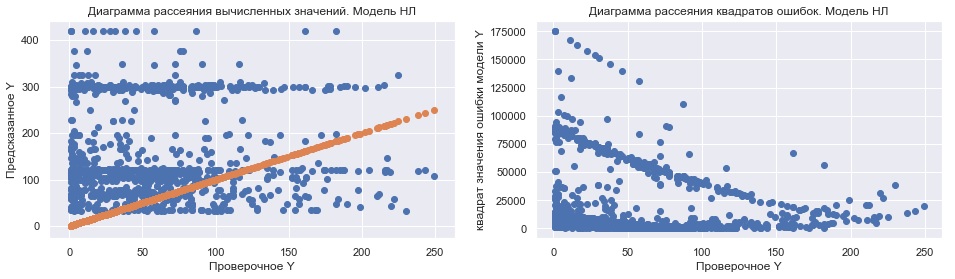

In [378]:
# вывод
if (len (y_pred) == len (data_part)):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.scatter( data_part, y_pred.reshape(-1, 1) )
    plt.scatter( data_part, data_part,)
    plt.title(u'Диаграмма рассеяния вычисленных значений. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'Предсказанное Y')
    
    plt.subplot(122)
    plt.scatter( data_part, pow( data_part - y_pred.reshape(-1, 1), 2 ) )
    plt.title(u'Диаграмма рассеяния квадратов ошибок. Модель НЛ');
    plt.xlabel(u'Проверочное Y')
    plt.ylabel(u'квадрат значения ошибки модели Y')

else:
    print len (y_pred), len (data_part), "Размеры массивоов не совпадают"

In [379]:
r2 = metrics.r2_score( data_part, y_pred.reshape(-1, 1))
mae = metrics.mean_absolute_error(data_part, y_pred.reshape(-1, 1))
mse = metrics.mean_squared_error(data_part, y_pred.reshape(-1, 1))
print "r2  = {:>20.2f}".format(r2)
print "mae = {:>20.2f}".format(mae)
print "mse = {:>20.2f}".format(mse)

r2  =                -7.58
mae =               115.24
mse =             22271.02


## Вывод

В ходе выполнения лабораторной работы были определены лингвистические переменные (ЛП), для каждой ЛП были заданы числовые диапазоны и описаны терм-множества. На основе терм-множеств была сформирована база знаний.


Были совершены три итерации. Первая итерация показала коэффициент детерминации, равный -13.26, средний модуль отклонения 192.03. 
Во второй итерации были отредактированы терм-множества и база знаний. Коэффициент детерминации составил -4.81, средний модуль отклонения 108.75.
В третьей итерации проверялась точность модели на части данных, в частности, для одного времени года. Для зимы коэффициент детерминации составил -0.44, средний модуль отклонения 127.62.
